# Imports

In [ ]:
import numpy as np
import pandas as pd
import torch
import random
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn as nn
import math
from facenet_pytorch import MTCNN
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import Dataset
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from PIL import Image, ImageDraw
from tqdm.auto import tqdm
import torch.optim as optim
import warnings
import requests
import pickle

warnings.filterwarnings('ignore')

# Load Datasets

Я подготовила данные лиц 500 людей CelebA-500. Они уже выровнены. Скачать можно тут: https://disk.yandex.ru/d/S8f03spLIA1wrw Внутри: - celebA_imgs — папка с выровненными картинками; - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id; - celebA_train_split.txt — файл со сплитом на train/val/test. Эти данные — часть открытого датасета CelebA, который один из стандартных для обучения моделей, связанных с лицами.

In [2]:
anno = pd.read_csv('data/celebA_train_500/celebA_anno.txt', sep=' ', verbose=True, names=['image', 'face_id'])
anno.head()

Tokenization took: 15.63 ms
Type conversion took: 0.00 ms
Parser memory cleanup took: 0.00 ms


,image,face_id
0,000001.jpg,0
1,000404.jpg,0
2,003415.jpg,0
3,004390.jpg,0
4,018062.jpg,0


In [3]:
# путь к изображениям, после слеша пишем id
path_to_images = 'data/celebA_train_500/celebA_imgs/'

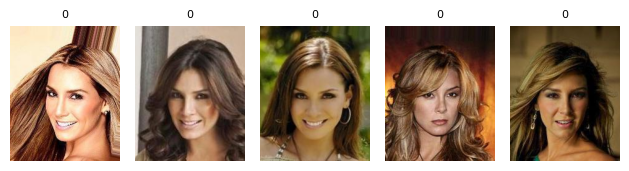

In [4]:
for i, (image_name, face_id) in enumerate(zip(anno['image'].head(5), anno['face_id'].head(5))):
    img = mpimg.imread(path_to_images + image_name)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(str(face_id), fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

вот такие у нас тут изображения, сделаем loader для них

In [5]:
tvt_split = pd.read_csv('data/celebA_train_500/celebA_train_split.txt', sep=' ', verbose=True, names=['image', 'split_id'])
tvt_split['split_id'].unique()

Tokenization took: 0.00 ms
Type conversion took: 15.64 ms
Parser memory cleanup took: 0.00 ms


array([0, 1, 2], dtype=int64)

объеденим все в один датафрейм с face_id, split_id, image

In [6]:
faces = pd.merge(anno, tvt_split, on=['image'], how='inner')
assert faces.shape[0] == tvt_split.shape[0] == anno.shape[0]
faces.head()

,image,face_id,split_id
0,000001.jpg,0,0
1,000404.jpg,0,0
2,003415.jpg,0,0
3,004390.jpg,0,0
4,018062.jpg,0,0


In [7]:
class CelebADataset(Dataset):
    def __init__(self, dataframe, path_to_images, transform=None):
        self.dataframe = dataframe
        self.path_to_images = path_to_images
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_name = self.dataframe.iloc[idx]['image']
        face_id = self.dataframe.iloc[idx]['face_id']
        img_path = self.path_to_images + image_name
        image = mpimg.imread(img_path)

        if self.transform:
            image = self.transform(image)

        return image, face_id

    def show(self, idx):
        image, face_id = self.__getitem__(idx)
        image = image.permute(1, 2, 0).numpy()  
        plt.imshow(image)
        plt.title(f"Face ID: {face_id}")
        plt.axis('off')
        plt.show()

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_df = faces[faces['split_id'] == 0]
valid_df = faces[faces['split_id'] == 1]
test_df = faces[faces['split_id'] == 2]

In [9]:
train_x = CelebADataset(train_df, path_to_images, transform=transform)
valid_x = CelebADataset(valid_df, path_to_images, transform=transform)
test_x = CelebADataset(test_df, path_to_images, transform=transform)

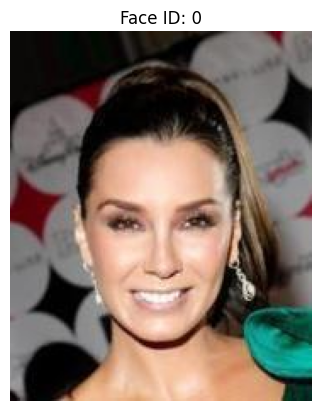

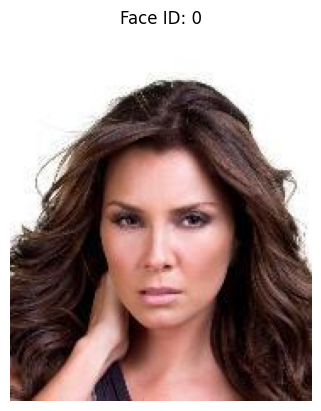

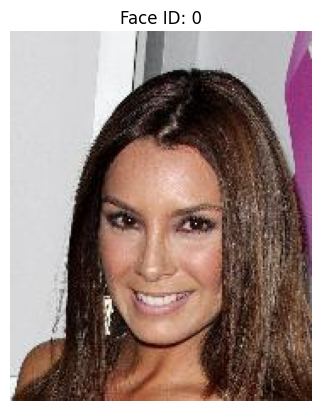

(None, None, None)

In [10]:
train_x.show(12), valid_x.show(3), test_x.show(1)

в целом мы готовы начинать писать наш общий пайплайн

# Face Detection

In [11]:
def draw_mtcnn_boxes_with_model(image_tensor, model, threshold=0.5):
    """
    Использует переданную MTCNN модель для обнаружения лиц и рисует рамки вокруг лиц.

    :param image_tensor: Тензор изображения в формате [3, H, W].
    :param model: Инициализированная модель MTCNN.
    :param threshold: Порог вероятности для фильтрации предсказаний.
    :return: PIL-изображение с нарисованными рамками.
    """
    # Разнормализация (преобразование из [-1, 1] в [0, 1])
    image = image_tensor.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
    # image = (image * 0.5 + 0.5).clip(0, 1)  # Возвращаем значения в диапазон [0, 1]

    # Преобразование в PIL-формат
    image = (image * 255).astype("uint8")  # [0, 1] -> [0, 255]
    image = Image.fromarray(image)

    # Обнаружение лиц
    boxes, probs = model.detect(image)

    # Рисуем рамки
    draw = ImageDraw.Draw(image)
    if boxes is not None:
        for box, prob in zip(boxes, probs):
            if prob >= threshold:
                x1, y1, x2, y2 = box
                draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

    return image

In [12]:
mtcnn = MTCNN(keep_all=True, device='cpu')

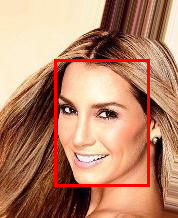

In [13]:
draw_mtcnn_boxes_with_model(train_x[0][0], mtcnn)

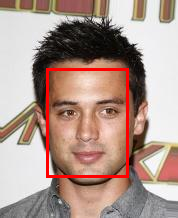

In [14]:
draw_mtcnn_boxes_with_model(train_x[123][0], mtcnn)

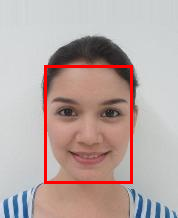

In [15]:
draw_mtcnn_boxes_with_model(train_x[4324][0], mtcnn)

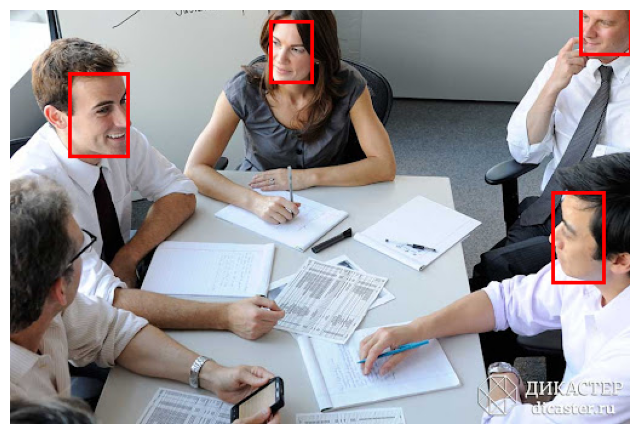

In [16]:
url = "https://lh6.googleusercontent.com/proxy/fE552yBgGHqcMEdLgwAo6teP1SdDYwNLtfmZOy45_i92IA4khsb4Ic7ERHWItS86rgcAOc8JJqt-zxW13vC89apok45SzGO8xx4cW77cMhWwDS0nrhDD0wP-pQXGvWXpX0_4hSc04U0"
response = requests.get(url, stream=True)
image = Image.open(response.raw).convert('RGB')
transform = transforms.Compose([
    transforms.ToTensor(),
])
image_tensor = transform(image)

result_image = draw_mtcnn_boxes_with_model(image_tensor, mtcnn, threshold=0.5)
plt.figure(figsize=(8, 8))
plt.imshow(result_image)
plt.axis('off')
plt.show()

работает, хорошо, проверили не только на изображениях из датасета, но и на лицах из инета

# Face Aligment

для этой части pipeline можно использовать тоже MTCNN т.к. добавив параметр `landmarks=True` в 
`mtcnn.detect(   , landmarks=True)` мы будем получать также ключевые точки лиц

In [17]:
def draw_mtcnn_boxes_with_landmarks(image_tensor: torch.Tensor, model, threshold=0.5, draw=False):
    """
    image_tensor из CelebA без обработок C x H x W
    """
    image = image_tensor.permute(1, 2, 0).numpy()
    # image = (image * 0.5 + 0.5).clip(0, 1)
    image = (image * 255).astype("uint8")
    image = Image.fromarray(image)
    boxes, probs, landmarks = model.detect(image, landmarks=True)

    landmarks_dict = {
        'left_eye': None,
        'right_eye': None,
        'nose': None,
        'mouth_left': None,
        'mouth_right': None
    }

    if not draw:
        result = []
        try:
            for box, prob, landmark in zip(boxes, probs, landmarks):
                if prob >= threshold:
                    result.append({
                        "box": box,
                        "landmarks": {
                            'left_eye': landmark[0],
                            'right_eye': landmark[1],
                            'nose': landmark[2],
                            'mouth_left': landmark[3],
                            'mouth_right': landmark[4]
                        }
                    })
            return result
        except Exception:
            print("Не найдено изображение лица")
            return -1

    draw = ImageDraw.Draw(image)
    if boxes is not None:
        for box, prob, landmark in zip(boxes, probs, landmarks):
            if prob >= threshold:
                x1, y1, x2, y2 = box
                draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
                for idx, (lx, ly) in enumerate(landmark):
                    part_name = list(landmarks_dict.keys())[idx]
                    draw.ellipse([lx - 2, ly - 2, lx + 2, ly + 2], fill="red")
                    landmarks_dict[part_name] = (lx, ly)

    return image if draw else landmarks_dict

In [18]:
draw_mtcnn_boxes_with_landmarks(train_x[4124][0], mtcnn)

[{'box': array([45.64641571044922, 66.92335510253906, 128.2128143310547,
         186.86721801757812], dtype=object),
  'landmarks': {'left_eye': array([70.731689453125, 112.56047058105469], dtype=object),
   'right_eye': array([107.7823257446289, 112.38606262207031], dtype=object),
   'nose': array([91.08474731445312, 136.64849853515625], dtype=object),
   'mouth_left': array([71.80615234375, 154.162841796875], dtype=object),
   'mouth_right': array([107.4902114868164, 153.10882568359375], dtype=object)}}]

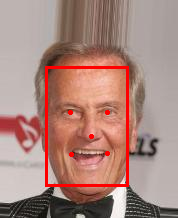

In [19]:
draw_mtcnn_boxes_with_landmarks(train_x[4124][0], mtcnn, draw=True)

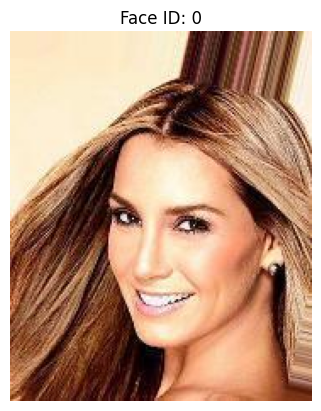

In [20]:
train_x.show(0)

In [21]:
def align_and_crop_image_tensor(image_tensor, show=False):
    if type(image_tensor) is torch.Tensor: 
        image = image_tensor.permute(1, 2, 0).numpy()
        # image = (image * 0.5 + 0.5).clip(0, 1)
        image = (image * 255).astype("uint8")
        pil_image = Image.fromarray(image)
    elif type(image_tensor) is Image.Image:
        pil_image = image_tensor
        image_tensor = TF.to_tensor(image_tensor)
    if show:
        pil_image.show()
    
    landmarks = draw_mtcnn_boxes_with_landmarks(image_tensor, mtcnn)

    x1,y1,x2,y2 = landmarks[0]['box']
    left_eye = landmarks[0]['landmarks']['left_eye']
    right_eye = landmarks[0]['landmarks']['right_eye']
    angle = math.atan2(right_eye[1]-left_eye[1], right_eye[0]-left_eye[0]) * 180 / math.pi
    
    return pil_image.crop((x1,y1,x2,y2)).rotate(angle=angle, resample=Image.BICUBIC)

In [22]:
class AlignedCelebADataset(Dataset):
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Возвращает выровненное изображение и метку.
        """
        image_tensor, face_id = self.dataset[idx]  # Путь к изображению
        try:
            processed_image = align_and_crop_image_tensor(image_tensor)
            if self.transforms:
                image_tensor = self.transforms(processed_image)
        except TypeError as e:
            print(f"Не найдено изображение {idx}")
            return -1, -1
            
        return image_tensor, torch.tensor(face_id)

In [23]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
])

train_dataset = AlignedCelebADataset(train_x, transforms=transform)
valid_dataset = AlignedCelebADataset(valid_x, transforms=transform)
test_dataset = AlignedCelebADataset(test_x, transforms=transform)

In [24]:
from torch.utils.data import Subset

# elements_ids_to_delete = []
# for i in tqdm(range(len(train_dataset))):
#     im, l = train_dataset[i]
#     if type(im) is not torch.Tensor:  # Условие для "плохих" элементов
#         elements_ids_to_delete.append(i)
#         print(elements_ids_to_delete)
# !!! Ниже взял индексы элемнетов, где mtcnn не нашла лицо
elements_ids_to_delete = [383, 878, 887, 2099, 3513, 5255, 5749]
remaining_indices = [i for i in range(len(train_dataset)) if i not in elements_ids_to_delete]

filtered_dataset = Subset(train_dataset, remaining_indices)

print(f"Изначальное количество элементов: {len(train_dataset)}")
print(f"Очищенное количество элементов: {len(filtered_dataset)}")

train_dataset = filtered_dataset

Изначальное количество элементов: 8544
Очищенное количество элементов: 8537


In [25]:
# elements_ids_to_delete = []
# for i in tqdm(range(len(test_dataset))):
#     im, l = test_dataset[i]
#     if type(im) is not torch.Tensor:  # Условие для "плохих" элементов
#         elements_ids_to_delete.append(i)
#         print(elements_ids_to_delete)
# !!! Ниже взял индексы элемнетов, где mtcnn не нашла лицо
elements_ids_to_delete = [167]
remaining_indices = [i for i in range(len(test_dataset)) if i not in elements_ids_to_delete]

filtered_dataset = Subset(test_dataset, remaining_indices)

print(f"Изначальное количество элементов: {len(test_dataset)}")
print(f"Очищенное количество элементов: {len(filtered_dataset)}")

test_dataset = filtered_dataset

Изначальное количество элементов: 1589
Очищенное количество элементов: 1588


# Face Recognition

In [26]:
print("У нас столько уникальных лиц (классов)",faces['face_id'].nunique())

У нас столько уникальных лиц (классов) 500


In [27]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Model With CrossEntropy Loss

In [45]:
model = models.efficientnet_b0()
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 500)
criterion = nn.CrossEntropyLoss()
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-3)

In [30]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()  # Режим обучения
    total_loss, correct_predictions, total_samples = 0.0, 0, 0

    for inputs, labels in tqdm(dataloader, desc="Train Loader"):
        inputs, labels = inputs.to(device), labels.to(device)  # На устройство
        optimizer.zero_grad()  # Обнуление градиентов
        outputs = model(inputs)  # Прямой проход
        loss = criterion(outputs, labels)  # Вычисление ошибки (без softmax!)

        loss.backward()  # Обратный проход
        optimizer.step()  # Шаг оптимизации

        # Применяем softmax только для предсказания
        total_loss += loss.item() * inputs.size(0)
        _, pred_label = torch.max(outputs, 1)
        correct_predictions += (pred_label == labels).sum().item()
        total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy


In [49]:
def validate(model, dataloader, criterion, device):
    model.eval()  # Переводим модель в режим оценки
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Отключаем подсчет градиентов
        for inputs, labels in tqdm(dataloader, "Validation Loader"):
            # Переносим данные на устройство
            inputs, labels = inputs.to(device), labels.to(device)

            # Прямой проход
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Сбор метрик
            total_loss += loss.item() * inputs.size(0)
            _, pred_label = torch.max(outputs, 1)
            correct_predictions += (pred_label == labels).sum().item()
            total_samples += inputs.size(0)
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

    return avg_loss, accuracy


In [46]:
model.load_state_dict(torch.load('model_checkpoints/ce/best.pth'))

<All keys matched successfully>

In [33]:
validate(model, valid_loader, criterion, device), validate(model, test_loader, criterion, device)

Validation Loader:   0%|          | 0/59 [00:00<?, ?it/s]

Validation Loss: 1.3330, Validation Accuracy: 0.7215


Validation Loader:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss: 1.4157, Validation Accuracy: 0.7204


(1.4157345165834019, 0.7204030226700252)

In [47]:
face_reco_model = nn.Sequential(*list(model.children())[:-1])

## IDR Metric

In [33]:
# Если вы работаете с данными, которые даны по ссылке,
# то эта ячейка поможет их загрузить
from collections import defaultdict
import os
# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./data/celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('./data/celebA_ir/celebA_distractors')

In [34]:
def compute_embeddings(model, images_list, path=None):
    '''
    Compute embeddings from the trained model for a list of images.
    params:
        model: trained neural network model that takes images and outputs embeddings
        images_list: list of image paths to compute embeddings for
        path: optional; path to save the embeddings as a file
    output:
        list: list of model embeddings. Each embedding corresponds to image names from images_list
    '''
    model.eval()
    preprocess = transforms.Compose([
        transforms.ToTensor(),        
        transforms.Resize((224, 224)),
    ])
    embeddings = []
    with torch.no_grad():
        for image_path in tqdm(images_list):
            image = Image.open(path + image_path)
            input_tensor = preprocess(image).unsqueeze(0).to(device)
            embedding = model(input_tensor).view(-1).cpu().numpy()
            embeddings.append(embedding)
    return embeddings

In [ ]:
query_embeddings = compute_embeddings(face_reco_model, 
                                      query_img_names, path='data/celebA_ir/celebA_query/')
distractors_embeddings = compute_embeddings(face_reco_model,
                                            distractors_img_names, 
                                            path='data/celebA_ir/celebA_distractors/')

  0%|          | 0/1222 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

In [195]:
def compute_sampled_embeddings(embeddings, sample_size):
    '''
    Extract a random sample of embeddings of size `sample_size`.
    If `sample_size` exceeds the size of embeddings, return all embeddings.
    '''
    if sample_size >= len(embeddings):
        return embeddings
    sampled_indices = random.sample(range(len(embeddings)), sample_size)
    return [embeddings[i] for i in sampled_indices]

def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings, sample_size=None):
    positive_similarities = []
    for cls, img_list in tqdm(query_dict.items()):
        indices = [query_img_names.index(img) for img in img_list if img in query_img_names]
        if sample_size:
            indices = random.sample(indices, min(sample_size, len(indices)))
        for i, idx1 in enumerate(indices):
            for idx2 in indices[i+1:]:
                similarity = cosine_similarity([query_embeddings[idx1]], [query_embeddings[idx2]])[0][0]
                positive_similarities.append(similarity)
    return positive_similarities

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings, sample_size=None):
    negative_similarities = []
    classes = list(query_dict.keys())
    for i, cls1 in tqdm(enumerate(classes)):
        for cls2 in classes[i+1:]:
            indices_cls1 = [query_img_names.index(img) for img in query_dict[cls1] if img in query_img_names]
            indices_cls2 = [query_img_names.index(img) for img in query_dict[cls2] if img in query_img_names]
            if sample_size:
                indices_cls1 = random.sample(indices_cls1, min(sample_size, len(indices_cls1)))
                indices_cls2 = random.sample(indices_cls2, min(sample_size, len(indices_cls2)))
            for idx1 in indices_cls1:
                for idx2 in indices_cls2:
                    similarity = cosine_similarity([query_embeddings[idx1]], [query_embeddings[idx2]])[0][0]
                    negative_similarities.append(similarity)
    return negative_similarities

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings, sample_size=None):
    distractor_similarities = []
    query_embeddings_sampled = compute_sampled_embeddings(query_embeddings, sample_size) if sample_size else query_embeddings
    distractors_embeddings_sampled = compute_sampled_embeddings(distractors_embeddings, sample_size) if sample_size else distractors_embeddings
    for query_emb in tqdm(query_embeddings_sampled):
        for distractor_emb in distractors_embeddings_sampled:
            similarity = cosine_similarity([query_emb], [distractor_emb])[0][0]
            distractor_similarities.append(similarity)
    return distractor_similarities

def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
    '''
    Compute identification rate using precomputed cosine similarities between pairs
    at given fpr.
    params:
      cosine_query_pos: cosine similarities between positive pairs from query
      cosine_query_neg: cosine similarities between negative pairs from query
      cosine_query_distractors: cosine similarities between negative pairs
                                from query and distractors
      fpr: false positive rate at which to compute TPR
    output:
      float: threshold for given fpr
      float: TPR at given FPR
    '''
    all_negatives = np.concatenate((cosine_query_neg, cosine_query_distractors))
    threshold = np.percentile(all_negatives, (1 - fpr) * 100)

    true_positives = np.sum(np.array(cosine_query_pos) >= threshold)
    total_positives = len(cosine_query_pos)
    tpr = true_positives / total_positives if total_positives > 0 else 0.0

    return threshold, tpr

Ячейка ниже проверяет, что код работает верно:

In [196]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [197]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

И ячейки для ее проверки:

In [198]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [199]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

функции реализованы верно

In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)

In [ ]:
for fpr in [0.5, 0.3, 0.2, 0.1, 0.05]:
    x, y = compute_ir(cosine_query_pos, cosine_query_neg,
                      cosine_query_distractors, fpr=fpr)
    print(f"Threshold: {x}  TPR: {y}  FPR: {fpr}")

## Model With ArcFaceLoss

In [69]:
class ArcFaceHead(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFaceHead, self).__init__()
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x, labels):
        x = F.normalize(x, dim=1)
        W = F.normalize(self.weight, dim=1)

        cosine = torch.matmul(x, W.t())

        theta = torch.acos(torch.clamp(cosine, -1.0, 1.0))
        target_logits = torch.cos(theta + self.m)

        one_hot = F.one_hot(labels, num_classes=cosine.size(1)).float()
        logits = one_hot * target_logits + (1.0 - one_hot) * cosine
        logits *= self.s

        return logits

class ArcFaceEfficientNet(nn.Module):
    def __init__(self, num_classes, s=30.0, m=0.50):
        super(ArcFaceEfficientNet, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)

        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()  
        self.embedding_size = in_features

        self.arcface = ArcFaceHead(in_features=in_features, out_features=num_classes, s=s, m=m)

    def forward(self, x, labels=None):
        features = self.backbone(x)
        
        if labels is not None:
            logits = self.arcface(features, labels)
            return logits
            
        return features

In [70]:
model = ArcFaceEfficientNet(num_classes=500)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [201]:
with open('./model_af.pkl', 'rb+') as f:
    model = pickle.load(f)
model = model.to(device)

In [202]:
validate(model, valid_loader, criterion, device), validate(model, test_loader, criterion, device)

Validation Loader:   0%|          | 0/59 [00:00<?, ?it/s]

Validation Loss: 1.4766, Validation Accuracy: 0.7109


Validation Loader:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss: 1.5561, Validation Accuracy: 0.7122


(1.556145552423799, 0.7122166246851386)

In [ ]:
query_embeddings = compute_embeddings(model, 
                                      query_img_names, path='data/celebA_ir/celebA_query/')
distractors_embeddings = compute_embeddings(model,
                                            distractors_img_names, 
                                            path='data/celebA_ir/celebA_distractors/')

cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)

for fpr in [0.5, 0.3, 0.2, 0.1, 0.05,]:
    x, y = compute_ir(cosine_query_pos, cosine_query_neg,
                    cosine_query_distractors, fpr=fpr)
    print(f"Threesold: {x}  TPR: {y}  FPR: {fpr}")


# Pipeline check

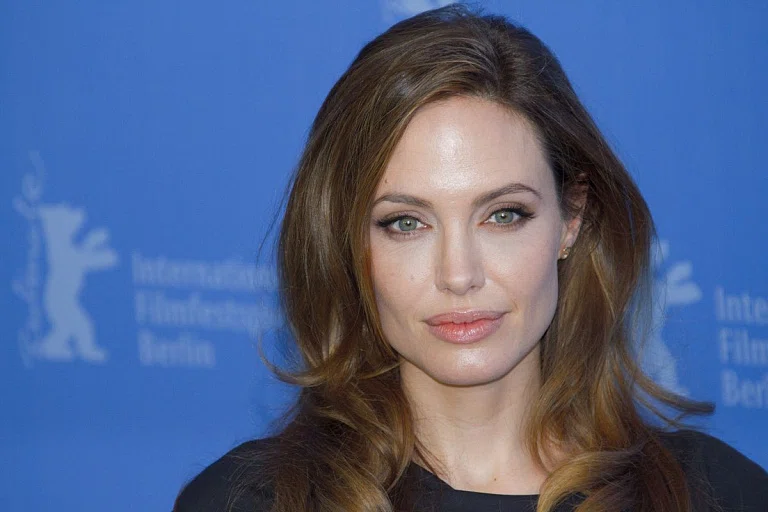

In [146]:
import requests
url = "https://cdn.tochka.by/upload/resize_cache/85892/77d4f87216fd3cb6bce9ef7ad82eaee2/iblock/a77/5f7hkal2hf5e9vfq1mxehbguodndfcpo.jpg"
response = requests.get(url, stream=True)
image1 = Image.open(response.raw).convert('RGB')
image1

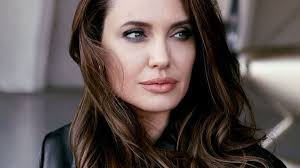

In [147]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRy_vgDjBq1sWb58kklRgImg7UrObQ9Q7x2Ug&s"
response = requests.get(url, stream=True)
image2 = Image.open(response.raw).convert('RGB')
image2

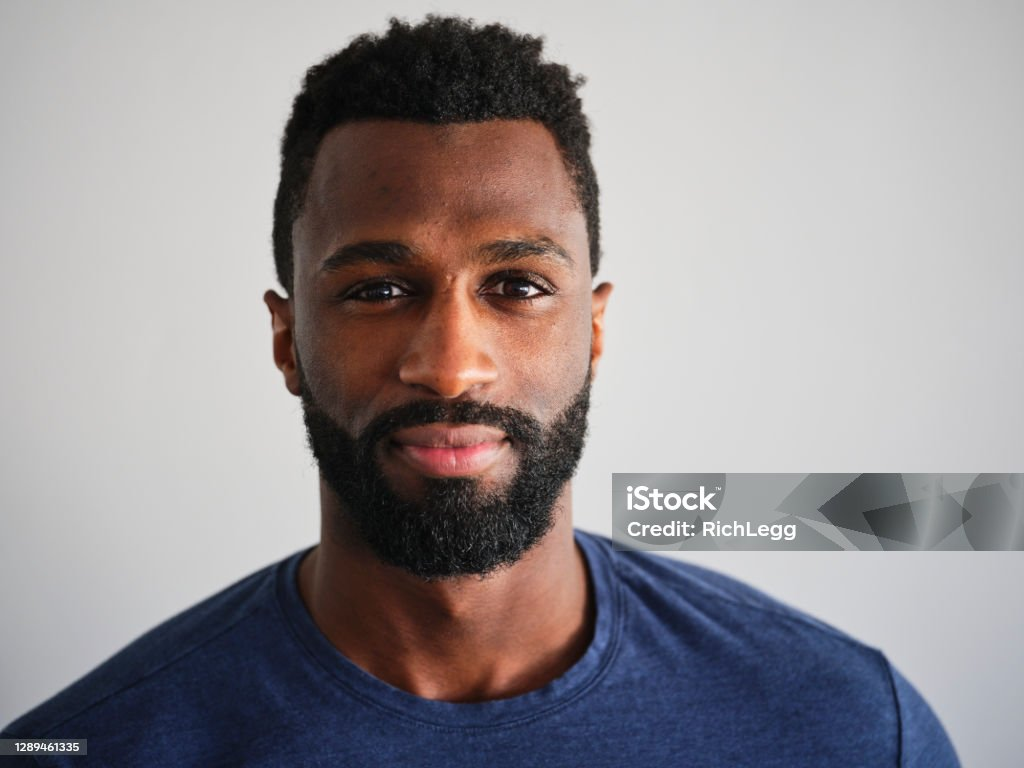

In [185]:
url = "https://media.istockphoto.com/id/1289461335/ru/%D1%84%D0%BE%D1%82%D0%BE/%D0%BF%D0%BE%D1%80%D1%82%D1%80%D0%B5%D1%82-%D0%BA%D1%80%D0%B0%D1%81%D0%B8%D0%B2%D0%BE%D0%B3%D0%BE-%D1%87%D0%B5%D1%80%D0%BD%D0%BE%D0%B3%D0%BE-%D1%87%D0%B5%D0%BB%D0%BE%D0%B2%D0%B5%D0%BA%D0%B0.jpg?s=1024x1024&w=is&k=20&c=XUgeJu0Ip2Aq-WA4nO7dpj-V6ykm1nuPypEyZxCMDyw="
response = requests.get(url, stream=True)
image3 = Image.open(response.raw).convert('RGB')
image3

In [150]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
])

def pipeline_preprocess_image(image):
    image_tensor = TF.to_tensor(image)
    try:
        processed_image = align_and_crop_image_tensor(image_tensor)
        image_tensor = transform(processed_image)
    except TypeError as e:
        print(e)
        return -1, -1
            
    return image_tensor
    

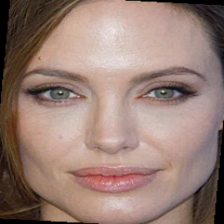

In [186]:
TF.to_pil_image(pipeline_preprocess_image(image1))

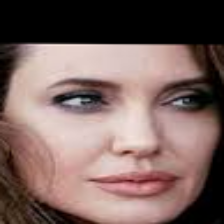

In [187]:
TF.to_pil_image(pipeline_preprocess_image(image2))

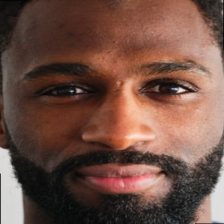

In [188]:
TF.to_pil_image(pipeline_preprocess_image(image3))

In [189]:
threesold = 0.32999784648418423 # для FPR = 0.1 в 
image_tensor1 = pipeline_preprocess_image(image1)
image_tensor2 = pipeline_preprocess_image(image2)
image_tensor3 = pipeline_preprocess_image(image3)

emb1 = model(image_tensor1.unsqueeze(0).to(device)).cpu().detach().numpy()
emb2 = model(image_tensor2.unsqueeze(0).to(device)).cpu().detach().numpy()
emb3 = model(image_tensor3.unsqueeze(0).to(device)).cpu().detach().numpy()

In [190]:
def is_similar(emb1, emb2):
    print(cosine_similarity(emb1, emb2))
    if cosine_similarity(emb1, emb2) > threesold:
        print("Одинаковые люди")
    else:
        print("Неодинаковые")

In [192]:
is_similar(emb1, emb2)

[[0.45304826]]
Одинаковые люди


In [193]:
is_similar(emb1, emb3)

[[0.1817591]]
Неодинаковые


In [194]:
is_similar(emb2, emb3)

[[0.11788293]]
Неодинаковые


# Выводы

- Модель обученая на CrossEntropyLoss дольше сходилась по сравнению с ArcFace моделью,
а также имела меньший *accurancy* на valid/test выборках.
- Модель ArcFace быстрее сошлась, а также имеет чуть лушче результаты по *IDR метрике* и *accurancy*